In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Variables_bins as Variables_bins
import Utilities.Functions as Functions
import Utilities.Sys_unc_variables as Sys_unc
from Utilities.ipython_exit import exit

np.seterr(divide='ignore', invalid='ignore')

print ('Success')

Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_data":True,
          "FLATTEN":False, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":True, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          'Load_pi0_signal_DetVars':False,
          "Load_pi0_signal":False,
          'Load_lepton_dirac':False,
          'Load_pi0_dirac':False}

# Params, samples = Functions.create_sample_list(Params)
Params, samples = Functions.new_create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run3 samples: 
['overlay', 'dirtoverlay', 'beamoff', 'beamgood', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee']


In [3]:
samples_dict = Functions.Load_initial_pkls(samples, Params, loc_pkls, "_full_Finished")

for sample in samples_dict:
    print(f"{sample} length is " + str(len(samples_dict[sample])))
print("Loading these variables:")
print(samples_dict[sample].keys())

overlay length is 748702
dirtoverlay length is 389264
beamoff length is 3211097
beamgood length is 1104349
2_ee length is 45159
10_ee length is 44463
20_ee length is 46022
50_ee length is 44579
100_ee length is 45304
150_ee length is 44031
Loading these variables:
Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps',
       'topological_score', 'swtrig_pre', 'swtrig_post', 'crtveto', 'run',
       'sub', 'evt', 'rse_id'],
      dtype='object')


## Applying Software Trigger

In [4]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304

In [5]:
# swtrig_dict = {}
Pre_swtrig_dict = {}
swtrig = {}
apply_swtrig = True
if(apply_swtrig): print("Applying software trigger!")
for sample in samples_dict:
    Pre_swtrig_dict[sample] = len(samples_dict[sample]) #Should weight this properly, i.e take sum of weights for the total number.
    if(apply_swtrig):
        # Apply_swtrig(samples_dict[sample])
        if Params["Run"]=="run1":
            swtrig[sample] = samples_dict[sample].query("swtrig_pre>0").copy()
        if Params["Run"]=="run3":
            swtrig[sample] = samples_dict[sample].query("swtrig_post==1").copy() #Took this from Owen's code, should check exactly what it's doing
            # swtrig[sample] = samples_dict[sample].query("swtrig_pre>0").copy()
    else: swtrig[sample] = samples_dict[sample].copy()
    if sample != "beamgood":
        Apply_flash_shift(swtrig[sample], sample)

Applying software trigger!


In [6]:
for sample in samples_dict:
    swtrig_effic = 100*(len(swtrig[sample])/Pre_swtrig_dict[sample])
    print(f"{sample} efficiency is " + str(swtrig_effic) + "%")

overlay efficiency is 82.60255749283426%
dirtoverlay efficiency is 80.12454272678696%
beamoff efficiency is 100.0%
beamgood efficiency is 100.0%
2_ee efficiency is 100.0%
10_ee efficiency is 100.0%
20_ee efficiency is 100.0%
50_ee efficiency is 100.0%
100_ee efficiency is 100.0%
150_ee efficiency is 100.0%


In [7]:
print(swtrig.keys())

dict_keys(['overlay', 'dirtoverlay', 'beamoff', 'beamgood', '2_ee', '10_ee', '20_ee', '50_ee', '100_ee', '150_ee'])


# Plotting variables before preselection

In [8]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = "100_ee"
if Params["Load_pi0_signal"]:
    HNL_mass = f"{HNL_mass}_pi0" #only plotting one at a time
variable = 'flash_time'

samples_plotting = {"overlay":swtrig["overlay"],
                    "dirtoverlay":swtrig["dirtoverlay"],
                    "beamoff":swtrig["beamoff"],
                    "signal":swtrig[HNL_mass]}

if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.run1_POT_scaling_dict["overlay"], #WAS using SF_overlay_run1
                    "dirtoverlay":Constants.run1_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run1_POT_scaling_dict["beamoff"],
                    "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.run3_POT_scaling_dict["overlay"],
                    "dirtoverlay":Constants.run3_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run3_POT_scaling_dict["beamoff"],
                    "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc

if Params["Load_data"] == True:
    data_dict = {"beamgood":samples_dict["beamgood"]}
    data_norm = {"beamgood":1.0} #No scaling as this is data, should have scaled MC to this POT.
    samples_plotting.update(data_dict)
    sample_norms.update(data_norm)
    
PT.HNL_scaling_calculator(samples_plotting,sample_norms)


The ratio of overlay to HNL events is 188797152

The ratio of all bkgs to HNL events is 1533105540



In [10]:
for sample in samples_plotting:
    print(sample)
    
print(Constants.Preselection_dict)

overlay
dirtoverlay
beamoff
signal
beamgood
{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.25 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'Fiducial_cut': 'min_y>-112 and max_y<112 and min_z>14 and max_z<1020 and min_x>9 and max_x<253', 'contained_fraction': 'contained_fraction > 0.9'}


## Plot data and MC

In [11]:
print(len(samples_plotting["overlay"]))
test = samples_plotting["overlay"].query('nslice>-1')
print(len(test))

618447
618447


In [12]:
def Plot_preselection_query(variable, samples=[], sample_norms=[], sample_weights_full=[], query="nslice>-1", xlabel=[],xlims=[0,0],bins=40,figsize=[10,10],
                            dpi=100,MergeBins=False, discrete=False, HNL_mass = 0, HNLplotscale=100000,density=False,legloc="best",logy = False,
                            cutline = 0.0, show_ev_nums=False, CalcSys=False, xticks=[], colours_sample={}, order=[], sys_dict={}, centre_bins=False,
                            hatch=False, ylabel="Events", Frame=True, arrow_place=[], ylimit=None, legsize=22, display=True, savefig=False,
                            savename="test", HNL_scale_label=False, title_name = "", chi_squared=False, Run="", dirt_frac_error=1.0):
    
    if(samples==[]): raise Exception("Specify samples dict") 
    if(xlabel==[]): xlabel=variable
    if(colours_sample=={}): colours_sample = {'overlay':Constants.sample_colours['overlay'],
                                              'dirtoverlay':Constants.sample_colours['dirtoverlay'],
                                              'beamoff':Constants.sample_colours['beamoff'],
                                              'signal':Constants.sample_colours['signal']}
    if(order==[]): order = ["beamoff","overlay","dirtoverlay"] #From bottom to top in stack
    if(sys_dict=={} and CalcSys==True): raise Exception("Specify systematic errors dict")
    
    beamgood=samples["beamgood"].query(query) #I should loop through samples instead, so don't always need data
    beamoff=samples["beamoff"].query(query)
    overlay=samples["overlay"].query(query)
    dirtoverlay=samples["dirtoverlay"].query(query)
    signal=samples["signal"].query(query)
    
    var_Data=beamgood[variable]
    var_Offbeam=beamoff[variable]
    var_Overlay=overlay[variable]
    var_Dirt=dirtoverlay[variable]
    var_HNL=signal[variable]
    
    variable_sample = {'overlay':var_Overlay,
                       'dirtoverlay':var_Dirt,
                       'beamoff':var_Offbeam,
                       'signal':var_HNL}
    
    weight_Offbeam=np.ones(len(var_Offbeam))*sample_norms["beamoff"]
    weight_Overlay=overlay["weight"]*sample_norms["overlay"]
    weight_Dirt=dirtoverlay["weight"]*sample_norms["dirtoverlay"]
    weight_signal=np.ones(len(var_HNL))*sample_norms["signal"]*HNLplotscale
    
    if sample_weights_full == []:
        weights_sample = {'overlay':weight_Overlay,
                          'dirtoverlay':weight_Dirt,
                          'beamoff':weight_Offbeam,
                          'signal':weight_signal}
    else: weights_sample=sample_weights_full
    
    if xlims[0] == 0 and xlims[1] == 0: xlims = [min(var_Overlay),max(var_Overlay)]
    
    if(isinstance(bins, int)):
        nbins=bins
        if centre_bins == True:
            bins=np.linspace(xlims[0],xlims[1],nbins+1)-0.5
        else:
            bins=np.linspace(xlims[0],xlims[1],nbins+1)
    else: nbins=len(bins)-1
    
    #all UNWEIGHTED hists
    totbkg=np.histogram(var_Offbeam,bins=bins,range=xlims)[0]+np.histogram(var_Dirt,bins=bins,range=xlims)[0]+np.histogram(var_Overlay,bins=bins,range=xlims)[0]
    offbkg=np.histogram(var_Offbeam,bins=bins,range=xlims)[0]
    overlaybkg=np.histogram(var_Overlay,bins=bins,range=xlims)[0]
    dirtbkg=np.histogram(var_Dirt,bins=bins,range=xlims)[0]
    
    #weighted hists
    offbkg_weighted=np.histogram(var_Offbeam,bins=bins,range=xlims,weights=weight_Offbeam)[0]
    overlaybkg_weighted=np.histogram(var_Overlay,bins=bins,range=xlims,weights=weight_Overlay)[0]
    dirtbkg_weighted=np.histogram(var_Dirt,bins=bins,range=xlims,weights=weight_Dirt)[0]
           
    #Testing Owens way, Err = sqrt(N*S.F**2)
    mc_w=np.histogram(var_Overlay,bins=bins,range=xlims,weights=weight_Overlay**2)
    off_w=np.histogram(var_Offbeam,bins=bins,range=xlims,weights=weight_Offbeam**2)
    dirt_w=np.histogram(var_Dirt,bins=bins,range=xlims,weights=weight_Dirt**2)
    
    off_err=np.sqrt(off_w[0])
    mc_err=np.sqrt(mc_w[0])
    dirt_err=np.sqrt(dirt_w[0])
    
    # stat_bkgerr=np.sqrt(offbkg_stat**2+overlaybkg_stat**2+dirtbkg_stat**2) #Adding stat errors in quadrature, my way
    stat_bkgerr=np.sqrt(off_err**2+mc_err**2+dirt_err**2) #Adding stat errors in quadrature
    tot_mcerr = stat_bkgerr
    
    if(CalcSys): #Owen's way of calculating systematics for arbitrary variable, using my new function
        frac_total = 0
        for frac_sys in sys_dict[variable]:
            frac_total += frac_sys**2 #Adding systematic sources of bkg in quadrature
        
        total_frac_sys = np.sqrt(frac_total)
        total_sys_err = frac_total*overlaybkg_weighted
        
        dirt_norm_err_fac = dirt_frac_error
        dirt_norm_err=dirtbkg_weighted*dirt_norm_err_fac
        tot_mcerr=np.sqrt( stat_bkgerr**2+total_sys_err**2+dirt_norm_err**2)
    
    if(MergeBins): #remove bins with zero bkg prediction
        bins_new=[]
        for i,bin_bkg in enumerate(totbkg):
            if(offbkg[i]>1 or overlaybkg[i]>1):
                bins_new.append(bins[i])
                
        bins_new.append(bins[-1])

        bins=bins_new
    
    # fig,ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=figsize,dpi=dpi) #Just variable plot
    fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize,dpi=dpi)
    
    plt.sca(ax[0])
        
    if(discrete):
        bins = np.arange(xlims[0], xlims[1] + 1.5) - 0.5
        xlims[0]=xlims[0]-1
        xlims[1]=xlims[1]+1
        ax[0].set_xticks(bins + 0.5)
        nbins=len(bins)-1
        
    x,y=np.histogram(var_Data,bins=bins,range=xlims,density=density)
    x1,y=np.histogram(var_Data,bins=bins,range=xlims)
    bin_center = [(y[i] + y[i+1])/2. for i in range(len(y)-1)]
    dat_val=x
    # dat_err=np.sqrt(x1)*Functions.safe_div(x,x1) #need to write one for arrays instead of single values.
    dat_err=np.sqrt(x1)*np.nan_to_num(x/x1)

    Datanum=dat_val.sum()
    Offbeamnum=sum(weight_Offbeam)
    Dirtnum=sum(weight_Dirt)
    Overlaynum=sum(weight_Overlay) 
    HNL_num=sum(weight_signal)
    
    if HNL_scale_label==False: HNL_label = f"{HNL_mass} MeV HNL"
    if HNL_scale_label==True: 
        theta = 1e-4
        theta_2 = theta**2
        new_theta_2 = np.sqrt(HNLplotscale)*theta_2
        theta_2_label = sci_notation(new_theta_2, decimal_digits=0)
        HNL_label = f"{HNL_mass} MeV HNL \n" + r"$|U_{\mu4}|^2$ = " + theta_2_label
    
    if show_ev_nums==True:
        labels_sample = {'overlay':fr"In-Cryo $\nu$ ({Overlaynum:.1f})",
                         'dirtoverlay':fr"Out-Cryo $\nu$ ({Dirtnum:.1f})",
                         'beamoff':f"Beam-Off ({Offbeamnum:.1f})",
                         'signal':f"{HNL_mass} MeV HNL ({HNL_num:.1f})"}
        # labels=[fr"In-Cryo $\nu$ ({Overlaynum:.1f})",fr"Out-Cryo $\nu$ ({Dirtnum:.1f})",f"Beam-Off ({Offbeamnum:.1f})"]
        sig_label = [f"{HNL_mass} MeV HNL ({HNL_num:.1f})"]
        data_label = f"{Run} NuMI Data ({Datanum:.0f})"
    else:
        labels_sample = {'overlay':fr"In-Cryo $\nu$",
                         'dirtoverlay':fr"Out-Cryo $\nu$",
                         'beamoff':f"Beam-Off",
                         'signal':HNL_label}
                         #'signal':f"{HNL_mass} MeV HNL"}
        # labels=[fr"In-Cryo $\nu$",fr"Out-Cryo $\nu$",f"Beam-Off"]
        sig_label = [HNL_label]
        data_label = f"{Run} NuMI Data"
    
    plt.errorbar(bin_center,dat_val,yerr=dat_err,fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label=data_label) #Plotting data

    varis, weights, colors, labels = [], [], [], []
    for sample in order:
        varis.append(variable_sample[sample])
        weights.append(weights_sample[sample])
        colors.append(colours_sample[sample])
        labels.append(labels_sample[sample])
            
    plot=plt.hist(varis,
              label=labels,
              range=xlims,bins=bins,
              histtype="stepfilled",
              stacked=True,density=density,linewidth=2,edgecolor="black",
              weights=weights, color=colors)
    
    upvals=np.append((plot[0][2]+tot_mcerr),(plot[0][2]+tot_mcerr)[-1])
    lowvals=np.append((plot[0][2]-tot_mcerr),(plot[0][2]-tot_mcerr)[-1])
    
    if hatch == False:
        plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)
    if hatch == True:
        plt.fill_between(y, lowvals, upvals,step="post",hatch='//',alpha=0,zorder=2)

    color=colours_sample["signal"]
    
    bkg_stack=varis
    bkg_stack_w=weights
    plt.hist(var_HNL,
              label=sig_label,
              range=xlims,bins=bins,
              stacked=True,density=density,
              weights= weight_signal,histtype="step",color=color,lw=4)
    
    if cutline != 0.0:
        plt.axvline(x=cutline, lw=3, color='green', linestyle = 'dashed')
    if arrow_place != []: #No idea how to fix this.
        plt.arrow(arrow_place[0], arrow_place[1], arrow_place[2], arrow_place[3], color='green', shape='full',fill=False, 
                  length_includes_head=True, overhang=0.0, head_width=-0.1, head_length=0.15, lw=3)
    
    if(logy == True):
        plt.yscale("log")
    else:
        plt.yscale("linear")
        
    if chi_squared==True:
        Exp_hist = offbkg_weighted+overlaybkg_weighted+dirtbkg_weighted
        Obs_hist = dat_val
        chi_square_val = Functions.Get_chi_squared(Obs_hist, Exp_hist, tot_mcerr)
        reduced_chi_squared = chi_square_val/(len(Obs_hist)) # degrees of freedom is no. of bins here
        print("d.o.f is " + str(len(Obs_hist)))
        print("Chi squared is " + str(chi_square_val))
        print("Reduced Chi squared is " + str(reduced_chi_squared))
        
        
    plt.ylabel(ylabel)
    plt.legend(loc=legloc,frameon=Frame, prop={'size': legsize})
    
    # plt.xlabel(xlabel)
    plt.xlim(xlims)
    if ylimit != None: plt.ylim(0,ylimit)
    
    if title_name != "":
        plt.title(title_name)
    
    #---Sub-plot----#
    plt.sca(ax[1])
    
    fracer_data=np.nan_to_num(np.sqrt(x1)/x1)
    x_err=fracer_data*x
    fracer_mc=np.nan_to_num(tot_mcerr/plot[0][2])
    
    rat_err_data=x_err*(1/plot[0][2])
    
    rat_err_mc=fracer_mc
    rat_err=np.sqrt(rat_err_data**2)

    rat_err_mc=np.nan_to_num(rat_err_mc) #other wise the next doesnt plot pro[erly]

    upvals= np.append(1+(rat_err_mc),1+(rat_err_mc)[-1]) #hate this but need to repeat last value to get bar on last bin to work, saw it here https://matplotlib.org/stable/gallery/lines_bars_and_markers/filled_step.html
    lowvals=np.append(1-(rat_err_mc),1-(rat_err_mc)[-1])


    plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)

    rat=np.nan_to_num(x/plot[0][2])
    rat[x==0]=1 #dont think this is a good way to deal with this

    rat_err=np.nan_to_num(rat*np.sqrt(fracer_mc**2+fracer_data**2))
       
    # plt.errorbar(bin_center,rat,yerr=rat_err,fmt='.',color='black',lw=3,capsize=3,elinewidth=1,label="data") #Had this before, but wrong I think
    plt.errorbar(bin_center,rat,yerr=fracer_data,fmt='.',color='black',lw=3,capsize=3,elinewidth=1,label="data")
    plt.ylabel("Data/MC")
    plt.axhline(1,ls='-',color='black')
    plt.axhline(1.1,ls='--',color='grey')
    plt.axhline(0.9,ls='--',color='grey')
    ylim = max(abs(np.nan_to_num(rat)))*1.1
    plt.ylim(0.7,1.3)
    # plt.ylim(0.9,1.1)
    plt.xlim(xlims)
    if xticks != []:
        plt.xticks(xticks)
    
    plt.xlabel(xlabel)
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    
    if savefig==True:
        plt.savefig(savename+".pdf")
        plt.savefig(savename+".png")
    if display == False:
        plt.close()

In [18]:
#Calculate sys
Calculate_sys = True
variable = 'crtveto'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000
    
no_swtrig = "swtrig_post>-99"
swtrig_new = "swtrig_post>0"
swtrig_old = "swtrig_pre>0"

if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
if variable=='trk_score_v':ylabel = 'Reconstructed objects'
else: ylabel='Events'
if variable=='nslice':xticks=[0,1]
else: xticks=[]

BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

Log_var = Variables_bins.Log_vars[variable]
cut_line = Variables_bins.cut_lines[variable]
arrow_place = Variables_bins.arrow_places_r3[variable]
print("Arrow place is " + str(arrow_place))

Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"
if arrow_place != []: end_name = "_arrow"
else: end_name = ""


Arrow place is [0.5, 300000.0, 0.6, 300000.0]


In [19]:
# savefig = False

# PT.Plot_preselection_query(variable, samples_plotting, sample_norms, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="No trigger")

# PT.Plot_preselection_query(variable, samples_plotting, sample_norms, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="Old trigger")

# PT.Plot_preselection_query(variable, samples_plotting, sample_norms, query="swtrig_post>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="New trigger")

# PT.Plot_preselection_query(variable, samples_plotting, sample_norms, query='nslice==1', xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="Neutrino slice")

In [20]:
# Calculate_sys = True
# variable = 'nslice'

# reload(PT)
# reload(Functions)
# reload(Constants)
# reload(Sys_unc)
# reload(Variables_bins)

# if Params["Run"] == "run1": 
#     flat_sys_vars_dict = Sys_unc.run1_Sys_unc
#     PLOTSCALE = 240000000
# if Params["Run"] == "run3": 
#     flat_sys_vars_dict = Sys_unc.run3_Sys_unc
#     PLOTSCALE = 240000000

# if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
# else: x_string=variable
# BINS = Variables_bins.Presel_bins[variable]
# XLIMS = [BINS[0],BINS[-1]]

In [21]:
# Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="No trigger")

# Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="Old trigger")

# Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_post>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="New trigger")

## Splitting into post and pre samples

In [22]:
samples_plotting['overlay'].keys()
root_dir = 'nuselection'

sample_loc = {"overlay":f'../NuMI_MC/SLIMMED_neutrinoselection_filt_'+Params["Run"]+'_overlay.root',
              "dirtoverlay":f'../NuMI_MC/neutrinoselection_filt_'+Params["Run"]+'_dirt_overlay.root',
              "beamoff":f'../NuMI_data/neutrinoselection_filt_'+Params["Run"]+'_beamoff.root',
              "signal":f'../NuMI_signal/KDAR_dump/sfnues/sfnues_KDAR_dump_',
              "pi0_signal":f'../NuMI_signal/KDAR_dump/sfnues/pi0/sfnues_KDAR_dump_',
              "beamgood":f'../NuMI_data/neutrinoselection_filt_'+Params["Run"]+'_beamon_beamgood.root'}

In [23]:
#Taken from Owen
beamgood, beamoff, overlay, dirtoverlay = {}, {}, {}, {}
sample_info = {"beamgood":beamgood, "beamoff":beamoff, "overlay":overlay, "dirtoverlay":dirtoverlay}
runsplit=16880
if(Params["Run"]=="run1"):
    print("nope")
else:
    sample_info["beamgood"]["POT_post"]=9.049e+19
    sample_info["beamgood"]["POT_pre"]=4.105e+20
    sample_info["beamgood"]["hwtrigs_post"]=1845342
    sample_info["beamgood"]["hwtrigs_pre"]=8519685
    sample_info["beamoff"]["hwtrigs_post"]=14382545.975000
    sample_info["beamoff"]["hwtrigs_pre"]= 18772346.425000

    # i split the MC at 16880 but this is actually somewhat arbitary (the run is just defined by the underlying unbiased event)
    # doesnt actually create a very approprieate split. #can also not split MC and just scale all together with updated threshold. (this actually gives best agreement)
    #i dont think suprising because we know simualtion vs data light yeild not great especially at low light level.
    file=uproot.open(f'../NuMI_MC/SLIMMED_neutrinoselection_filt_'+Params["Run"]+'_overlay.root')[root_dir]
    sample_info["overlay"]["POT_post"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()>=runsplit])
    sample_info["overlay"]["POT_pre"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()<runsplit])
    
    file=uproot.open(f'../NuMI_MC/neutrinoselection_filt_'+Params["Run"]+'_dirt_overlay.root')[root_dir]
    sample_info["dirtoverlay"]["POT_post"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()>=runsplit])
    sample_info["dirtoverlay"]["POT_pre"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()<runsplit])

    sample_info["dirtoverlay"]["NormScale_post"]=(sample_info["beamgood"]["POT_post"]/sample_info["dirtoverlay"]["POT_post"])*0.35
    sample_info["dirtoverlay"]["NormScale_pre"]=(sample_info["beamgood"]["POT_pre"]/sample_info["dirtoverlay"]["POT_pre"])*0.35

    sample_info["beamgood"]["NormScale"]=1

    sample_info["beamoff"]["NormScale_pre"]=(sample_info["beamgood"]["hwtrigs_pre"]/sample_info["beamoff"]["hwtrigs_pre"])*0.98
    sample_info["beamoff"]["NormScale_post"]=(sample_info["beamgood"]["hwtrigs_post"]/sample_info["beamoff"]["hwtrigs_post"])*0.98

    sample_info["overlay"]["NormScale_pre"]=(sample_info["beamgood"]["POT_pre"]/sample_info["overlay"]["POT_pre"])
    sample_info["overlay"]["NormScale_post"]=(sample_info["beamgood"]["POT_post"]/sample_info["overlay"]["POT_post"])

In [24]:
print("POTs:")
print("overlay pre: " + str(sample_info["overlay"]["POT_pre"]))
print("overlay post: " + str(sample_info["overlay"]["POT_post"]))

print("dirt pre: " + str(sample_info["dirtoverlay"]["POT_pre"]))
print("dirt post: " + str(sample_info["dirtoverlay"]["POT_post"]))
print()

print("Scalings:")
print("beamoff pre: " + str(sample_info["beamoff"]["NormScale_pre"]))
print("beamoff post: " + str(sample_info["beamoff"]["NormScale_post"]))

print("overlay pre: " + str(sample_info["overlay"]["NormScale_pre"]))
print("overlay post: " + str(sample_info["overlay"]["NormScale_post"]))

print("dirt pre: " + str(sample_info["dirtoverlay"]["NormScale_pre"]))
print("dirt post: " + str(sample_info["dirtoverlay"]["NormScale_post"]))

POTs:
overlay pre: 1.536880452623554e+21
overlay post: 4.524813975870935e+20
dirt pre: 6.014158669098967e+20
dirt post: 4.308466313048621e+20

Scalings:
beamoff pre: 0.4447654603731829
beamoff post: 0.12573818037108692
overlay pre: 0.26709949970360414
overlay post: 0.1999861220429123
dirt pre: 0.2388945950797889
dirt post: 0.07350991675176778


In [25]:
old_trig_samples = {"overlay":swtrig["overlay"].query("swtrig_pre>0"),
                    "dirtoverlay":swtrig["dirtoverlay"].query("swtrig_pre>0"),
                    "beamoff":swtrig["beamoff"].query("swtrig_pre>0"),
                    "signal":swtrig[HNL_mass].query("swtrig_pre>0")}

new_trig_samples = {"overlay":swtrig["overlay"].query("swtrig_post>0"),
                    "dirtoverlay":swtrig["dirtoverlay"].query("swtrig_post>0"),
                    "beamoff":swtrig["beamoff"].query("swtrig_post>0"),
                    "signal":swtrig[HNL_mass].query("swtrig_post>0")}

nslice_samples = {"overlay":swtrig["overlay"].query("nslice==1"),
                    "dirtoverlay":swtrig["dirtoverlay"].query("nslice==1"),
                    "beamoff":swtrig["beamoff"].query("nslice==1"),
                    "signal":swtrig[HNL_mass].query("nslice==1")}

weight_Offbeam=np.ones(len(samples_plotting["beamoff"]['nslice']))*np.where(samples_plotting["beamoff"]["run"]<16880, sample_info["beamoff"]["NormScale_pre"], sample_info["beamoff"]["NormScale_post"])
weight_Overlay=samples_plotting["overlay"]["weight"]*np.where(samples_plotting["overlay"]["run"]<runsplit, sample_info["overlay"]["NormScale_pre"], sample_info["overlay"]["NormScale_post"])
weight_Dirt=samples_plotting["dirtoverlay"]["weight"]*np.where(samples_plotting["dirtoverlay"]["run"]<runsplit, sample_info["dirtoverlay"]["NormScale_pre"], sample_info["dirtoverlay"]["NormScale_post"])

weight_signal=np.ones(len(samples_plotting["signal"]["nslice"]))*sample_norms["signal"]*PLOTSCALE
    
weights_sample_fixed = {'overlay':weight_Overlay,
                      'dirtoverlay':weight_Dirt,
                      'beamoff':weight_Offbeam,
                      'signal':weight_signal}

weight_Offbeam=np.ones(len(old_trig_samples["beamoff"]['nslice']))*np.where(old_trig_samples["beamoff"]["run"]<16880, sample_info["beamoff"]["NormScale_pre"], sample_info["beamoff"]["NormScale_post"])
weight_Overlay=old_trig_samples["overlay"]["weight"]*np.where(old_trig_samples["overlay"]["run"]<runsplit, sample_info["overlay"]["NormScale_pre"], sample_info["overlay"]["NormScale_post"])
weight_Dirt=old_trig_samples["dirtoverlay"]["weight"]*np.where(old_trig_samples["dirtoverlay"]["run"]<runsplit, sample_info["dirtoverlay"]["NormScale_pre"], sample_info["dirtoverlay"]["NormScale_post"])

weight_signal=np.ones(len(old_trig_samples["signal"]["nslice"]))*sample_norms["signal"]*PLOTSCALE
    
weights_sample_old_trig = {'overlay':weight_Overlay,
                      'dirtoverlay':weight_Dirt,
                      'beamoff':weight_Offbeam,
                      'signal':weight_signal}

weight_Offbeam=np.ones(len(new_trig_samples["beamoff"]['nslice']))*np.where(new_trig_samples["beamoff"]["run"]<16880, sample_info["beamoff"]["NormScale_pre"], sample_info["beamoff"]["NormScale_post"])
weight_Overlay=new_trig_samples["overlay"]["weight"]*np.where(new_trig_samples["overlay"]["run"]<runsplit, sample_info["overlay"]["NormScale_pre"], sample_info["overlay"]["NormScale_post"])
weight_Dirt=new_trig_samples["dirtoverlay"]["weight"]*np.where(new_trig_samples["dirtoverlay"]["run"]<runsplit, sample_info["dirtoverlay"]["NormScale_pre"], sample_info["dirtoverlay"]["NormScale_post"])

weight_signal=np.ones(len(new_trig_samples["signal"]["nslice"]))*sample_norms["signal"]*PLOTSCALE
    
weights_sample_new_trig = {'overlay':weight_Overlay,
                      'dirtoverlay':weight_Dirt,
                      'beamoff':weight_Offbeam,
                      'signal':weight_signal}

#nslice test
weight_Offbeam=np.ones(len(nslice_samples["beamoff"]['nslice']))*np.where(nslice_samples["beamoff"]["run"]<16880, sample_info["beamoff"]["NormScale_pre"], sample_info["beamoff"]["NormScale_post"])
weight_Overlay=nslice_samples["overlay"]["weight"]*np.where(nslice_samples["overlay"]["run"]<runsplit, sample_info["overlay"]["NormScale_pre"], sample_info["overlay"]["NormScale_post"])
weight_Dirt=nslice_samples["dirtoverlay"]["weight"]*np.where(nslice_samples["dirtoverlay"]["run"]<runsplit, sample_info["dirtoverlay"]["NormScale_pre"], sample_info["dirtoverlay"]["NormScale_post"])

weight_signal=np.ones(len(new_trig_samples["signal"]["nslice"]))*sample_norms["signal"]*PLOTSCALE
    
weights_sample_nslice = {'overlay':weight_Overlay,
                      'dirtoverlay':weight_Dirt,
                      'beamoff':weight_Offbeam,
                      'signal':weight_signal}

In [45]:
#Calculate sys
Calculate_sys = True
variable = 'crtveto'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000
    
no_swtrig = "swtrig_post>-99"
swtrig_new = "swtrig_post>0"
swtrig_old = "swtrig_pre>0"

if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
if variable=='trk_score_v':ylabel = 'Reconstructed objects'
else: ylabel='Events'
if variable=='nslice':xticks=[0,1]
else: xticks=[]

BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

Log_var = Variables_bins.Log_vars[variable]
cut_line = Variables_bins.cut_lines[variable]
arrow_place = Variables_bins.arrow_places_r3[variable]
# arrow_place = [[6.55, 4.1e4, 8, 4.1e4], [16.5, 4.1e4, 15, 4.1e4]]
print("Arrow place is " + str(arrow_place))

Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"
if arrow_place != []: end_name = "_arrow"
else: end_name = ""

print(BINS)

Arrow place is [0.5, 600000.0, 0.4, 600000.0]
[-0.5  0.5  1.5]


nbins 2
[0.5]
d.o.f is 2
Chi squared is 0.946707928739131
Reduced Chi squared is 0.4733539643695655


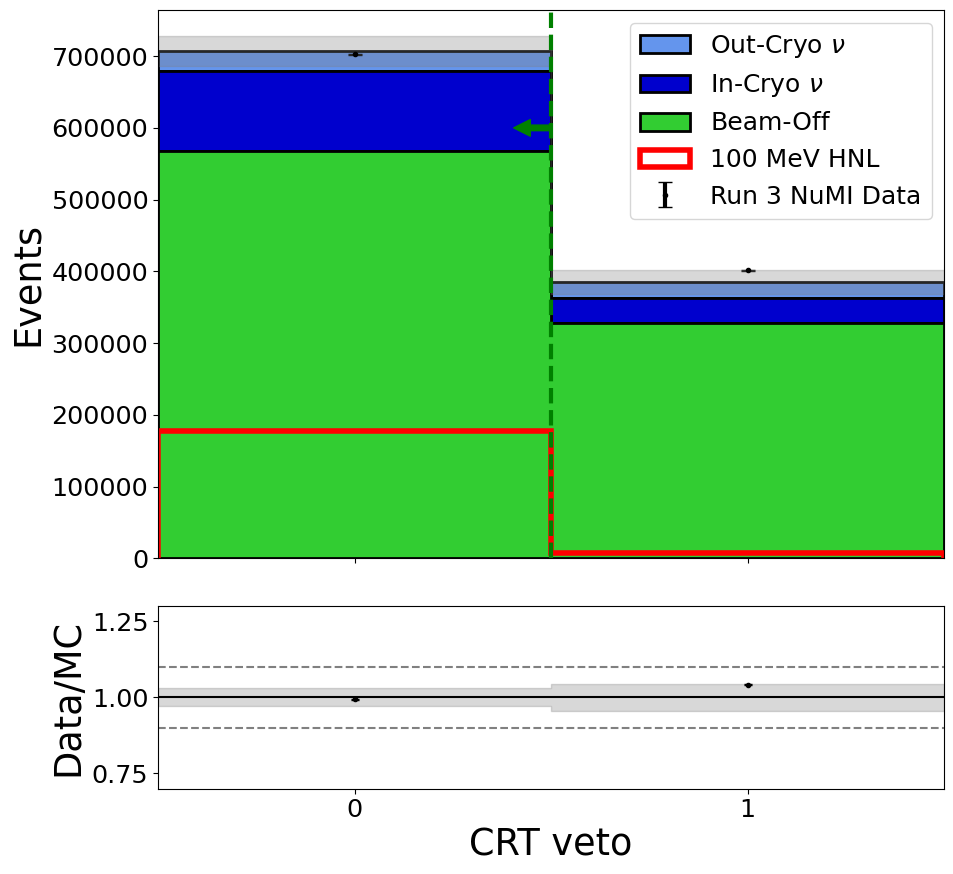

In [48]:
# PT.Plot_preselection_query(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_fixed, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="No trigger")

# PT.Plot_preselection_query(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_old_trig, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
#                                 HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
#                                 xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
#                                 title_name="Old trigger")

bins_test = [0,25.0]
bins_test = np.linspace(0, 23, 10)
bins_test = BINS
if (variable=='nslice') or (variable=='crtveto'):xticks=[0,1]
# arrow_place=[]
# cut_line=[]
print("nbins " + str(len(bins_test)-1))
query="swtrig_post>0" #Usual query
sample_weights_full=weights_sample_new_trig #usual 
print(cut_line)

PT.Plot_preselection_query(variable, samples_plotting, sample_norms, sample_weights_full=weights_sample_new_trig, query="swtrig_post>0",
                           xlabel=x_string, xlims=XLIMS, bins=bins_test, HNL_mass=100, HNLplotscale=PLOTSCALE, cutline=cut_line,legloc="upper right",
                           show_ev_nums=False, CalcSys=Calculate_sys,logy=Log_var, xticks = xticks, sys_dict=flat_sys_vars_dict, 
                           centre_bins=False, hatch=False, ylabel="Events", arrow_place=arrow_place, legsize=18, title_name="",
                           chi_squared=True, Run="Run 3", dirt_frac_error=0.75)

# plt.text(8.0, 2.35 , r"dirt error = " + str(75) + "%", fontsize=20)
# plt.text(8.0, 2.2 , r"$\chi_{\nu}^2 = $ 1.05", fontsize=20)

savefig=True

# Name = "Split_swtrig_"
Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}{end_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}{end_name}.pdf")


In [44]:
#Calculate sys
Calculate_sys = True
variable = 'n_pfps'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000
    
no_swtrig = "swtrig_post>-99"
swtrig_new = "swtrig_post>0"
swtrig_old = "swtrig_pre>0"

if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
if variable=='trk_score_v':ylabel = 'Reconstructed objects'
else: ylabel='Events'
if variable=='nslice':xticks=[0,1]
else: xticks=[]

BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

Log_var = Variables_bins.Log_vars[variable]
cut_line = Variables_bins.cut_lines[variable]
cut_line = 0.0
arrow_place = Variables_bins.arrow_places_r3[variable]
arrow_place = []
print("Arrow place is " + str(arrow_place))

Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"
if arrow_place != []: end_name = "_arrow"
else: end_name = ""

Arrow place is []


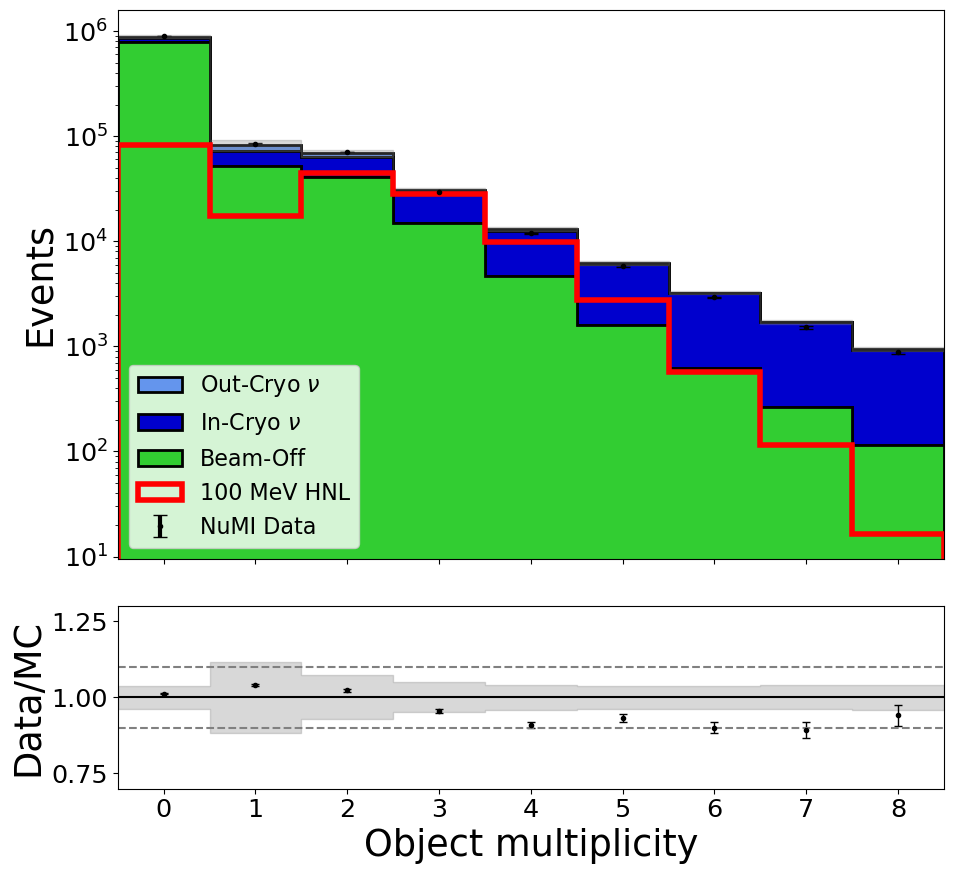

In [53]:
PT.Plot_preselection_query(variable, samples_plotting, sample_norms, sample_weights_full=weights_sample_new_trig, query="swtrig_post>0",
                           xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100, HNLplotscale=PLOTSCALE, cutline=cut_line,legloc="best",
                           show_ev_nums=False, CalcSys=Calculate_sys,logy=Log_var, xticks = [], sys_dict=flat_sys_vars_dict, 
                           centre_bins=False, hatch=False, ylabel="Events", arrow_place=arrow_place, legsize=16, title_name="")

savefig=True

Name = "Split_swtrig_"
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}{end_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}{end_name}.pdf")

In [ ]:

Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_fixed, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="No trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_old_trig, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="Old trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_new_trig, query="swtrig_post>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=False, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="")

Name = "Split_swtrig_"
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.pdf")


## Plotting just signal

In [ ]:
plt.figure(figsize=[10,10])

for HNL_mass in Constants.HNL_mass_samples:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[HNL_mass],label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
    
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# plt.yscale("log")
plt.legend()

plt.savefig("plots/Preselection_efficiencies/Signal_only_"+Params["Run"]+"_"+Params["Flat_state"]+".png")

# End of code